In [3]:
suppressMessages(library(Signac))
suppressMessages(library(Seurat))
suppressMessages(library(ggplot2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(tidyverse))
set.seed(1234)

suppressMessages(library(data.table))
library(cowplot)
library(ComplexHeatmap)

In [4]:
## Load links annotated by 1_Annotate_links_by_enhancers_geneHancerInter_filter_diffuse_DACRs.ipynb
all.links.tumor.normal <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/linkingGenes_v7.0/annotate.links/tumor_only_multiome/Pancan_all.links.filtered_by_zscore_diffused_links_annotated_by_GeneHancer_EpiMap_ENCODE_with_CNV_DAP_DEG_met.txt')



In [5]:
colors <- c(BRCA = "#fb9a99", BRCA_Basal = "#e31a1c",
             CESC = "#fdbf6f",
            'CESC_Non-squamous' = '#C69158',
            CRC = '#ff7f00',
            ccRCC = "#cab2d6", 
            GBM = "#6a3d9a" ,
            MM = "#b15928" ,
            HNSCC = "#b2df8a",
        OV = "#33a02c", 
            SKCM='#c9b92e',
        PDAC = "#a6cee3", 
            PDAC_Basal='#80A0AA',
        UCEC = "#1f78b4" )
colors.coverage <- c(BRCA = "#b06c6b", 
             CESC = "#b1864e",
            'CESC_Non-squamous' = '#C69158',
                     CRC = '#b35900',
            HNSCC = "#7d9c61",
        OV = "#24701f", 
        PDAC = "#74909f", 
        PDAC_Basal='#80A0AA',
        UCEC = "#16547e",
         SKCM='#B3B36B')

In [6]:
genes.gained <- all.links.tumor.normal %>% 
            filter(cnv=='Gain' & cnv.pct > 0.25 & N.cells.with.cnv > 2000) %>%
            mutate(gene.cancer = paste(gene, Cancer, sep ='_')) %>% 
            pull(gene.cancer) %>% 
            unique


In [7]:
combo.pancan.aver.Piece.normal <- readRDS('/diskmnt/Projects/snATAC_primary/PanCan_ATAC_data_freeze/v7.0/Multiome/Averaged/Averaged_by_Cancer_Piece_cell_type.normal_all_cells_multiome_obj.20230306.rds')



# PDAC heatmap

In [8]:
cancer.type = 'PDAC'
features <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) %>%
    dplyr::select(Cancer, peak, gene, ends_with('Annotation')) %>%
    distinct()  
dim(features)
head(features)

[1] 147   6

Cancer,peak,gene,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PDAC,chr4-8127462-8127962,ABLIM2,,,PLS
PDAC,chr4-8128064-8128564,ABLIM2,,Enhancer,"pELS,CTCF-bound"
PDAC,chr9-133252254-133252754,ABO,Enhancer,Enhancer,"dELS,CTCF-bound"
PDAC,chr17-81119470-81119970,ACTG1,Promoter/Enhancer,Promoter,"dELS,CTCF-bound"
PDAC,chr17-81912630-81913130,ACTG1,,Enhancer,"pELS,CTCF-bound"
PDAC,chr14-68695280-68695780,ACTN1,,Enhancer,"pELS,CTCF-bound"


In [9]:
#Table S3 PDAC tab
tosave <- (all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type))
fwrite(tosave, 
     glue::glue('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Suppl.tables/resubmission/Links_{cancer.type}_figure3d.tsv'), sep='\t')





In [10]:
row.anno <- features %>%
    dplyr::select(-gene) %>%
    filter(!duplicated(peak)) %>% 
    data.frame(row.names = 'peak')

head(row.anno[features$peak,])

,Cancer,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
,<chr>,<chr>,<chr>,<chr>
chr4-8127462-8127962,PDAC,,,PLS
chr4-8128064-8128564,PDAC,,Enhancer,"pELS,CTCF-bound"
chr9-133252254-133252754,PDAC,Enhancer,Enhancer,"dELS,CTCF-bound"
chr17-81119470-81119970,PDAC,Promoter/Enhancer,Promoter,"dELS,CTCF-bound"
chr17-81912630-81913130,PDAC,,Enhancer,"pELS,CTCF-bound"
chr14-68695280-68695780,PDAC,,Enhancer,"pELS,CTCF-bound"


In [11]:
#Fetch ATAC and RNA expression data from the averaged object
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'pancan'
toplot.atac <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$peak), slot = 'scale.data')
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'SCT'
toplot.rna <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$gene), slot = 'scale.data')

toplot.atac <- toplot.atac[,features$peak] %>% t
toplot.rna <- toplot.rna[,features$gene] %>% t

toplot.atac <- toplot.atac[,!grepl('oublet', colnames(toplot.atac))]
toplot.rna <- toplot.rna[,!grepl('oublet', colnames(toplot.rna))]

dim(toplot.rna)

meta <- combo.pancan.aver.Piece.normal@meta.data %>% filter(!grepl('oublet', rownames(.)))
meta <- meta %>% filter(Cancer == cancer.type & (Sample_type2=='Primary' | is.na(Sample_type2)))
toplot.atac <- toplot.atac[,rownames(meta)]
toplot.rna <- toplot.rna[,rownames(meta)]



[1] 147 142

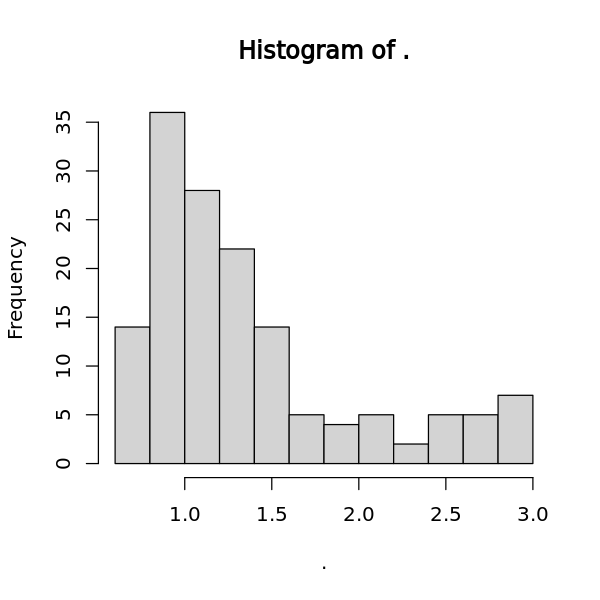

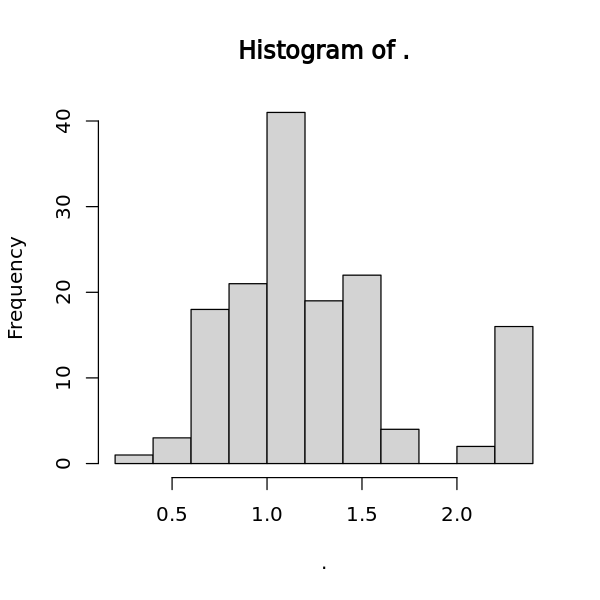

In [14]:

atac.sd <- sapply(rownames(toplot.atac), function(x){
    sd(t(toplot.atac[, grepl('Tumor', colnames(toplot.atac))])[,x])
})

rna.sd <- sapply(rownames(toplot.rna), function(x){
    sd(t(toplot.rna[, grepl('Tumor', colnames(toplot.rna))])[,x])
}) 

options(repr.plot.width=5, repr.plot.height=5)

atac.sd %>% hist
rna.sd %>% hist

if(cancer.type %in% c('PDAC')) {
    toplot.atac <- toplot.atac[atac.sd<2 & rna.sd<1.9,]
    toplot.rna <- toplot.rna[atac.sd<2 & rna.sd<1.9,]

}

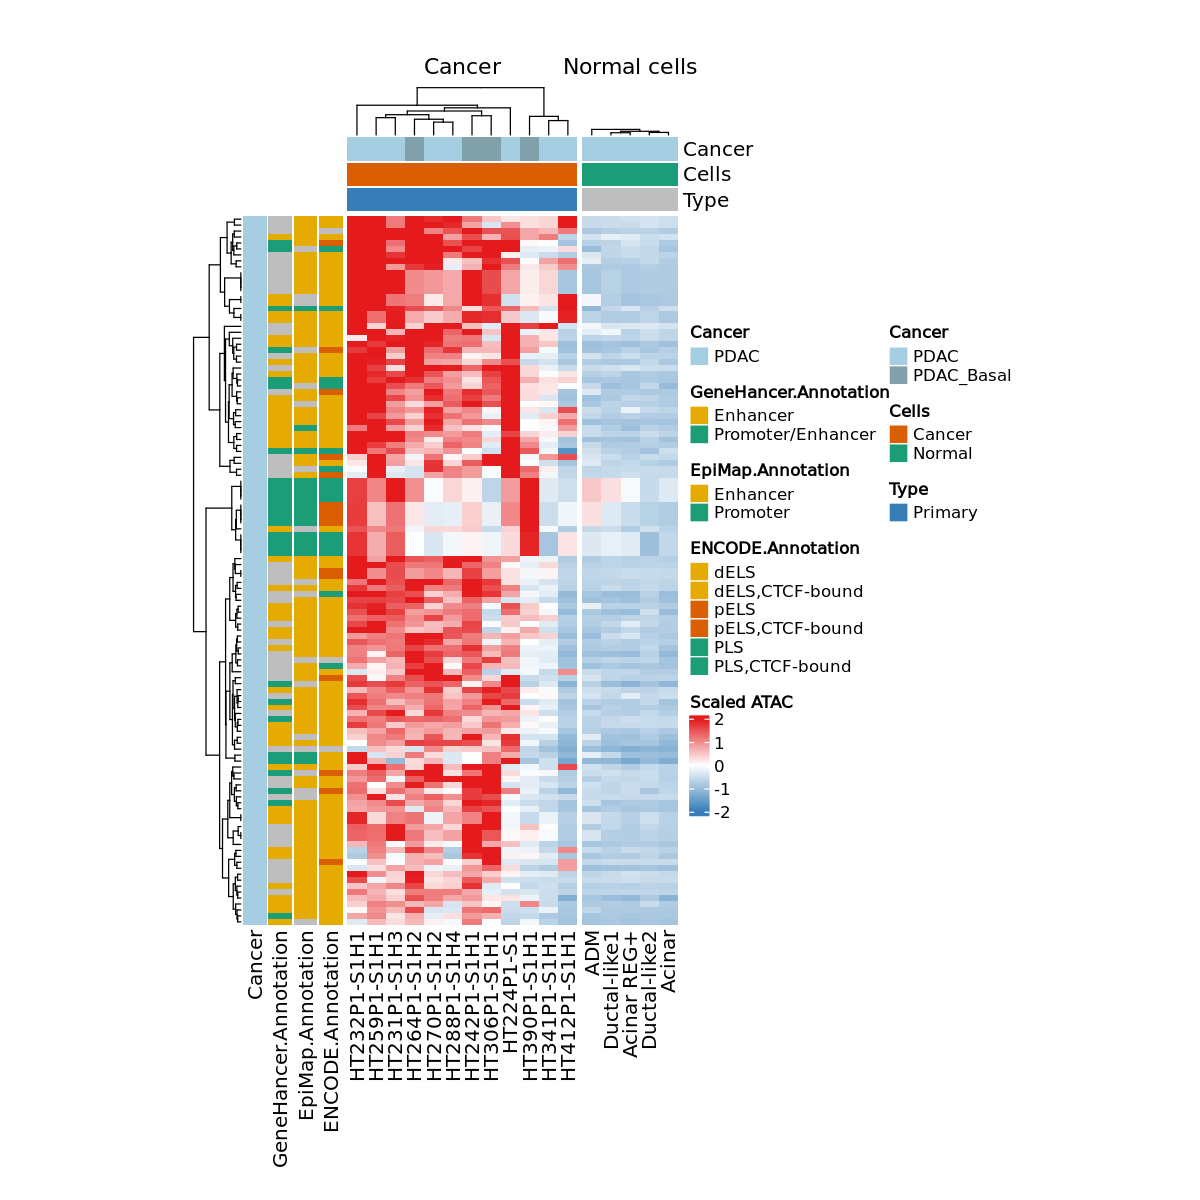

In [15]:
breaks = seq(-2 ,2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(c( '#377eb8','white','#e41a1c'))(length(breaks)))

column_ha = HeatmapAnnotation(Cancer = meta$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.atac)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                              Type = meta$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)

row_ha = rowAnnotation(df = row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , ],
                      col = list(Cancer = colors,
                          GeneHancer.Annotation = c('Promoter/Enhancer' = '#1b9e77',
                                                           'Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                EpiMap.Annotation = c('Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                ENCODE.Annotation = c('PLS' = '#1b9e77',
                                                      'PLS,CTCF-bound' = '#1b9e77',
                                                      'dELS' = '#e6ab02',
                                                      'dELS,CTCF-bound' = '#e6ab02',
                                                      'pELS' = '#d95f02',
                                                      'pELS,CTCF-bound' = '#d95f02',
                                                     'CTCF-only,CTCF-bound' = '#7570b3',
                                                     'DNase-H3K4me3' = '#a6761d',
                                                     'DNase-H3K4me3,CTCF-bound' = '#a6761d')
                                )
                      )


col.split <- case_when(is.na(meta$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

#row.split <- row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , 'Cancer']

colnames(toplot.atac) <- str_split_fixed(colnames(toplot.atac), '__', 5)[,3]

options(repr.plot.width=10, repr.plot.height=10)
p <- Heatmap(toplot.atac, name = "Scaled ATAC", cluster_column_slices = F,
             col = color.palette,cluster_rows = T, show_row_names = F,
             show_column_names = T, 
             top_annotation = column_ha,
             left_annotation = row_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
            column_split = col.split, 
             #row_split = row.split,
             width = unit(7, "cm"), height = unit(15, "cm"))

p



Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


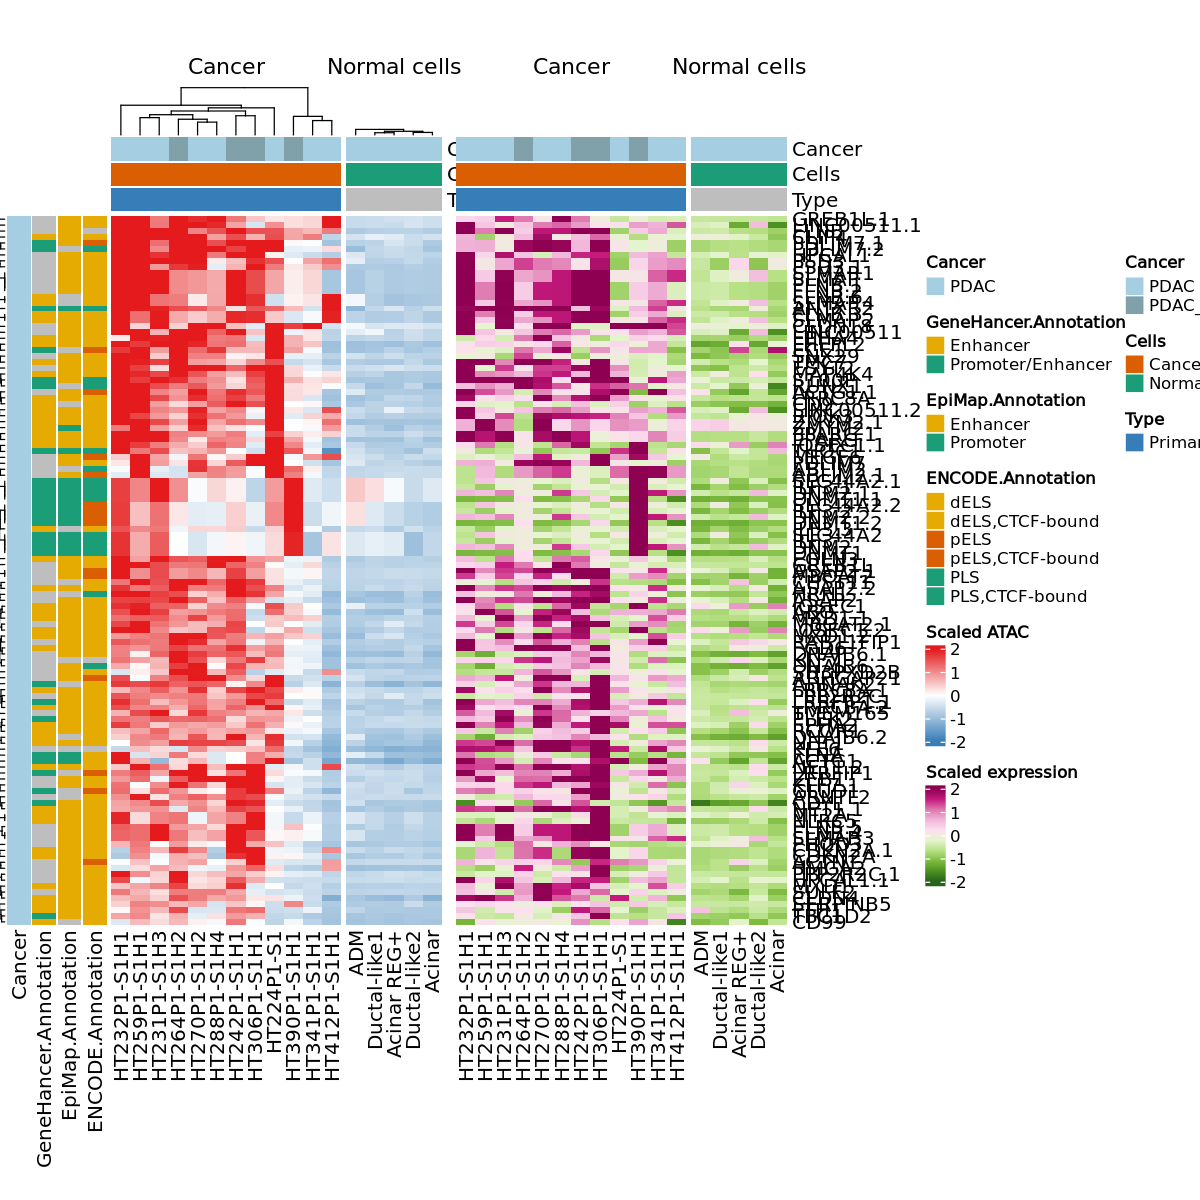

In [16]:
breaks = seq(-2 , 2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(rev(brewer.pal(10, "PiYG")))(length(breaks)))

#toplot.rna.order <- toplot.rna[row_order(p),column_order(p)]
toplot.rna.order <- toplot.rna[,as.numeric(unlist(column_order(p)))]
meta.order <- meta[as.numeric(unlist(column_order(p))),]

column_ha = HeatmapAnnotation(Cancer = meta.order$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.rna.order)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                               Type = meta.order$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)
options(repr.plot.width=10, repr.plot.height=10)

col.split <- case_when(is.na(meta.order$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

row.name <- str_split_fixed(rownames(toplot.rna.order), '[.]', 2)[,1]

colnames(toplot.rna.order) <- str_split_fixed(colnames(toplot.rna.order), '__', 5)[,3]

p2 <- Heatmap(toplot.rna.order, name = "Scaled expression", 
              col = color.palette,cluster_rows = F, cluster_columns = F, 
              show_row_names = T,
             show_column_names = T, 
             top_annotation = column_ha,
              #right_annotation = label_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
           column_split = col.split, 
             width = unit(7, "cm"), height = unit(15, "cm"))



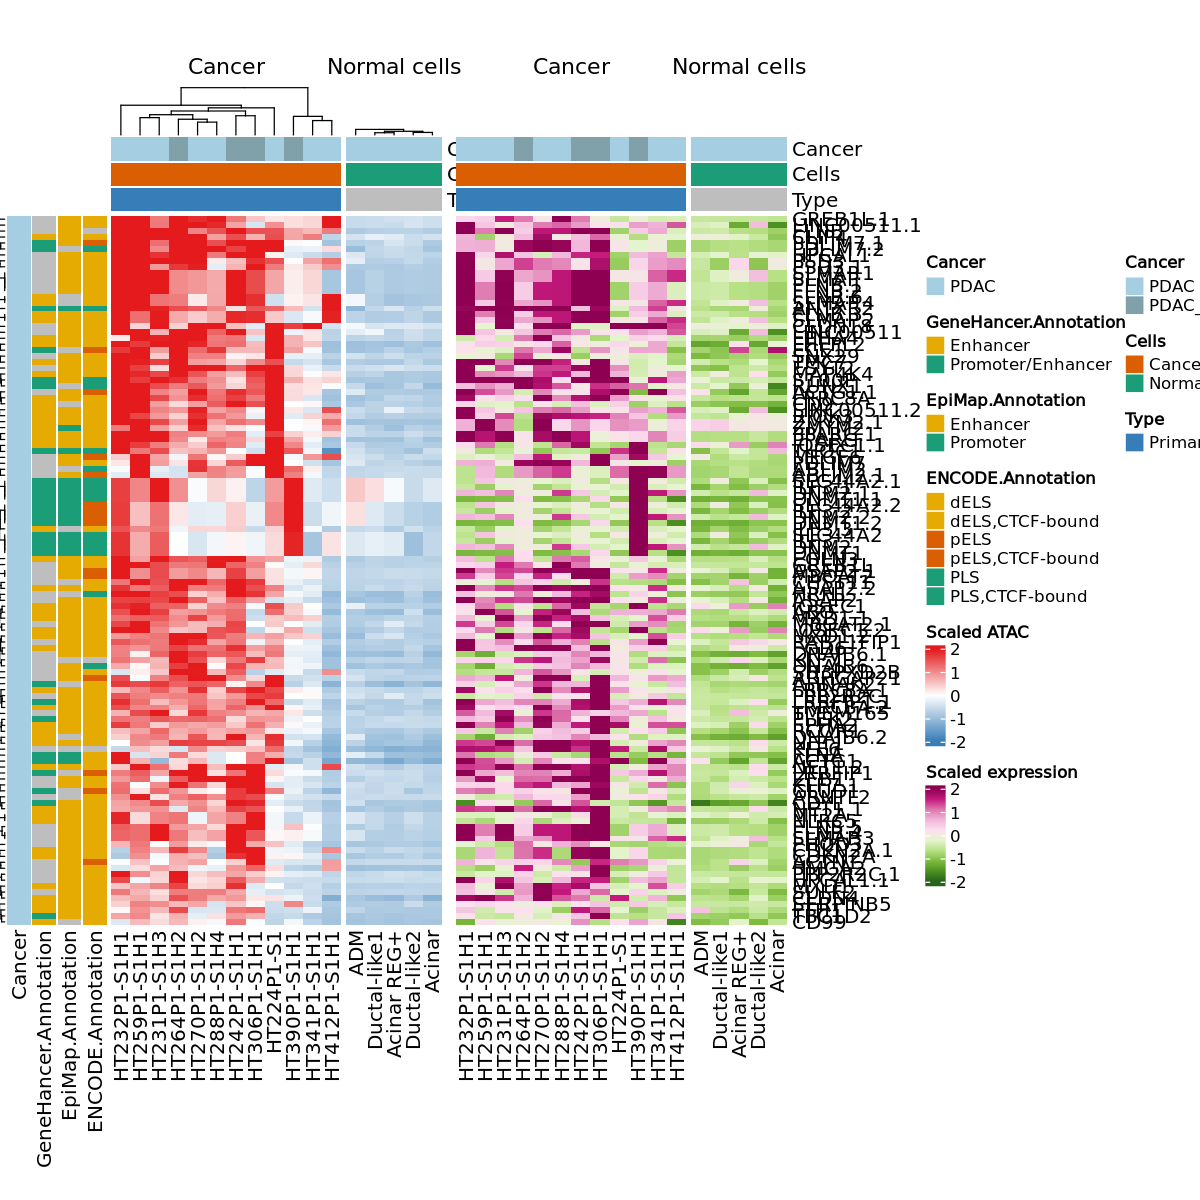

In [17]:
#Panel 3d
p + p2

# BRCA heatmap

In [18]:
cancer.type = 'BRCA'
features <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) %>%
    dplyr::select(Cancer, peak, gene, ends_with('Annotation')) %>%
    distinct()  
dim(features)
head(features)

[1] 242   6

Cancer,peak,gene,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
BRCA,chr15-89087977-89088477,ABHD2,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"
BRCA,chr17-81329414-81329914,ACTG1,Enhancer,Enhancer,"pELS,CTCF-bound"
BRCA,chr17-81346014-81346514,ACTG1,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
BRCA,chr17-81514538-81515038,ACTG1,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
BRCA,chr17-81860457-81860957,ACTG1,Promoter/Enhancer,Promoter,
BRCA,chr17-81891409-81891909,ACTG1,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"


In [ ]:
#Table S3 PDAC tab
tosave <- (all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type))
fwrite(tosave, 
     glue::glue('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Suppl.tables/resubmission/Links_{cancer.type}_figure3d.tsv'), sep='\t')



In [19]:
row.anno <- features %>%
    dplyr::select(-gene) %>%
    filter(!duplicated(peak)) %>% 
    data.frame(row.names = 'peak')

head(row.anno[features$peak,])

,Cancer,GeneHancer.Annotation,EpiMap.Annotation,ENCODE.Annotation
,<chr>,<chr>,<chr>,<chr>
chr15-89087977-89088477,BRCA,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"
chr17-81329414-81329914,BRCA,Enhancer,Enhancer,"pELS,CTCF-bound"
chr17-81346014-81346514,BRCA,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
chr17-81514538-81515038,BRCA,Promoter/Enhancer,Promoter,"pELS,CTCF-bound"
chr17-81860457-81860957,BRCA,Promoter/Enhancer,Promoter,
chr17-81891409-81891909,BRCA,Promoter/Enhancer,Promoter,"PLS,CTCF-bound"


In [20]:
#Fetch ATAC and RNA expression data from the averaged object
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'pancan'
toplot.atac <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$peak), slot = 'scale.data')
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'SCT'
toplot.rna <- FetchData(combo.pancan.aver.Piece.normal, vars = unique(features$gene), slot = 'scale.data')

toplot.atac <- toplot.atac[,features$peak] %>% t
toplot.rna <- toplot.rna[,features$gene] %>% t

toplot.atac <- toplot.atac[,!grepl('oublet', colnames(toplot.atac))]
toplot.rna <- toplot.rna[,!grepl('oublet', colnames(toplot.rna))]

dim(toplot.rna)

meta <- combo.pancan.aver.Piece.normal@meta.data %>% filter(!grepl('oublet', rownames(.)))
meta <- meta %>% filter(Cancer == cancer.type & (Sample_type2=='Primary' | is.na(Sample_type2)))
toplot.atac <- toplot.atac[,rownames(meta)]
toplot.rna <- toplot.rna[,rownames(meta)]



[1] 242 142

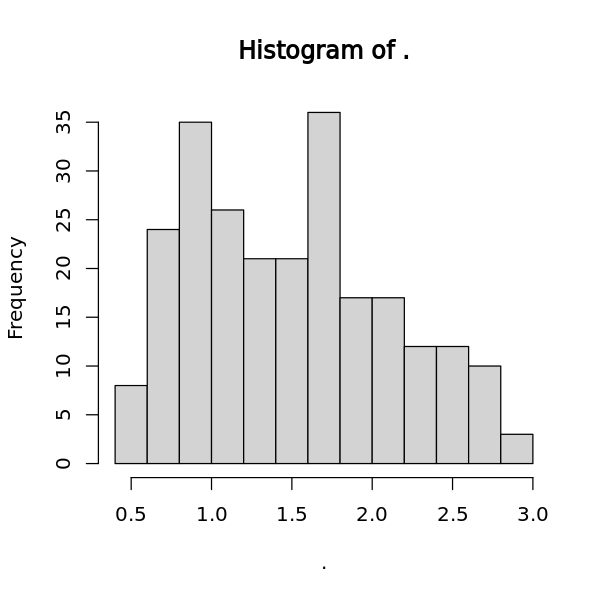

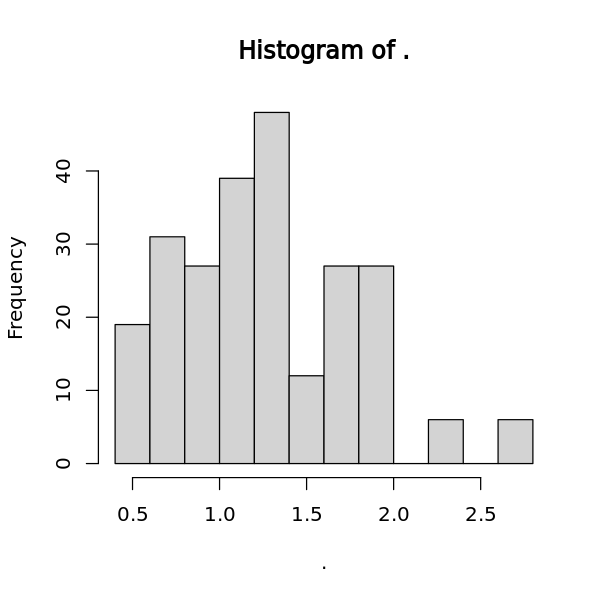

In [21]:

atac.sd <- sapply(rownames(toplot.atac), function(x){
    sd(t(toplot.atac[, grepl('Tumor', colnames(toplot.atac))])[,x])
})

rna.sd <- sapply(rownames(toplot.rna), function(x){
    sd(t(toplot.rna[, grepl('Tumor', colnames(toplot.rna))])[,x])
}) 

options(repr.plot.width=5, repr.plot.height=5)

atac.sd %>% hist
rna.sd %>% hist

if(cancer.type %in% c('PDAC')) {
    toplot.atac <- toplot.atac[atac.sd<2 & rna.sd<1.9,]
    toplot.rna <- toplot.rna[atac.sd<2 & rna.sd<1.9,]

}

In [22]:
breaks = seq(-2 ,2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(c( '#377eb8','white','#e41a1c'))(length(breaks)))

column_ha = HeatmapAnnotation(Cancer = meta$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.atac)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                              Type = meta$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)

row_ha = rowAnnotation(df = row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , ],
                      col = list(Cancer = colors,
                          GeneHancer.Annotation = c('Promoter/Enhancer' = '#1b9e77',
                                                           'Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                EpiMap.Annotation = c('Promoter' = '#1b9e77',
                                                          Enhancer = '#e6ab02'),
                                ENCODE.Annotation = c('PLS' = '#1b9e77',
                                                      'PLS,CTCF-bound' = '#1b9e77',
                                                      'dELS' = '#e6ab02',
                                                      'dELS,CTCF-bound' = '#e6ab02',
                                                      'pELS' = '#d95f02',
                                                      'pELS,CTCF-bound' = '#d95f02',
                                                     'CTCF-only,CTCF-bound' = '#7570b3',
                                                     'DNase-H3K4me3' = '#a6761d',
                                                     'DNase-H3K4me3,CTCF-bound' = '#a6761d')
                                )
                      )


col.split <- case_when(is.na(meta$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

#row.split <- row.anno[str_split_fixed(rownames(toplot.atac), '[.]',2)[,1] , 'Cancer']

colnames(toplot.atac) <- str_split_fixed(colnames(toplot.atac), '__', 5)[,3]

options(repr.plot.width=10, repr.plot.height=10)
p <- Heatmap(toplot.atac, name = "Scaled ATAC", cluster_column_slices = F,
             col = color.palette,cluster_rows = T, show_row_names = F,
             show_column_names = T, 
             top_annotation = column_ha,
             left_annotation = row_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
            column_split = col.split, 
             #row_split = row.split,
             width = unit(7, "cm"), height = unit(15, "cm"))

breaks = seq(-2 , 2, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(rev(brewer.pal(10, "PiYG")))(length(breaks)))

#toplot.rna.order <- toplot.rna[row_order(p),column_order(p)]
toplot.rna.order <- toplot.rna[,as.numeric(unlist(column_order(p)))]
meta.order <- meta[as.numeric(unlist(column_order(p))),]

column_ha = HeatmapAnnotation(Cancer = meta.order$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.rna.order)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                               Type = meta.order$Sample_type2,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Primary' = '#377eb8', 'Met' = '#e41a1c'))
)
options(repr.plot.width=10, repr.plot.height=10)

col.split <- case_when(is.na(meta.order$Sample_type2) ~ 'Normal cells',
                             TRUE ~ 'Cancer')

row.name <- str_split_fixed(rownames(toplot.rna.order), '[.]', 2)[,1]

colnames(toplot.rna.order) <- str_split_fixed(colnames(toplot.rna.order), '__', 5)[,3]

p2 <- Heatmap(toplot.rna.order, name = "Scaled expression", 
              col = color.palette,cluster_rows = F, cluster_columns = F, 
              show_row_names = T,
             show_column_names = T, 
             top_annotation = column_ha,
              #right_annotation = label_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
           column_split = col.split, 
             width = unit(7, "cm"), height = unit(15, "cm"))




Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); column_order(ht)`.”


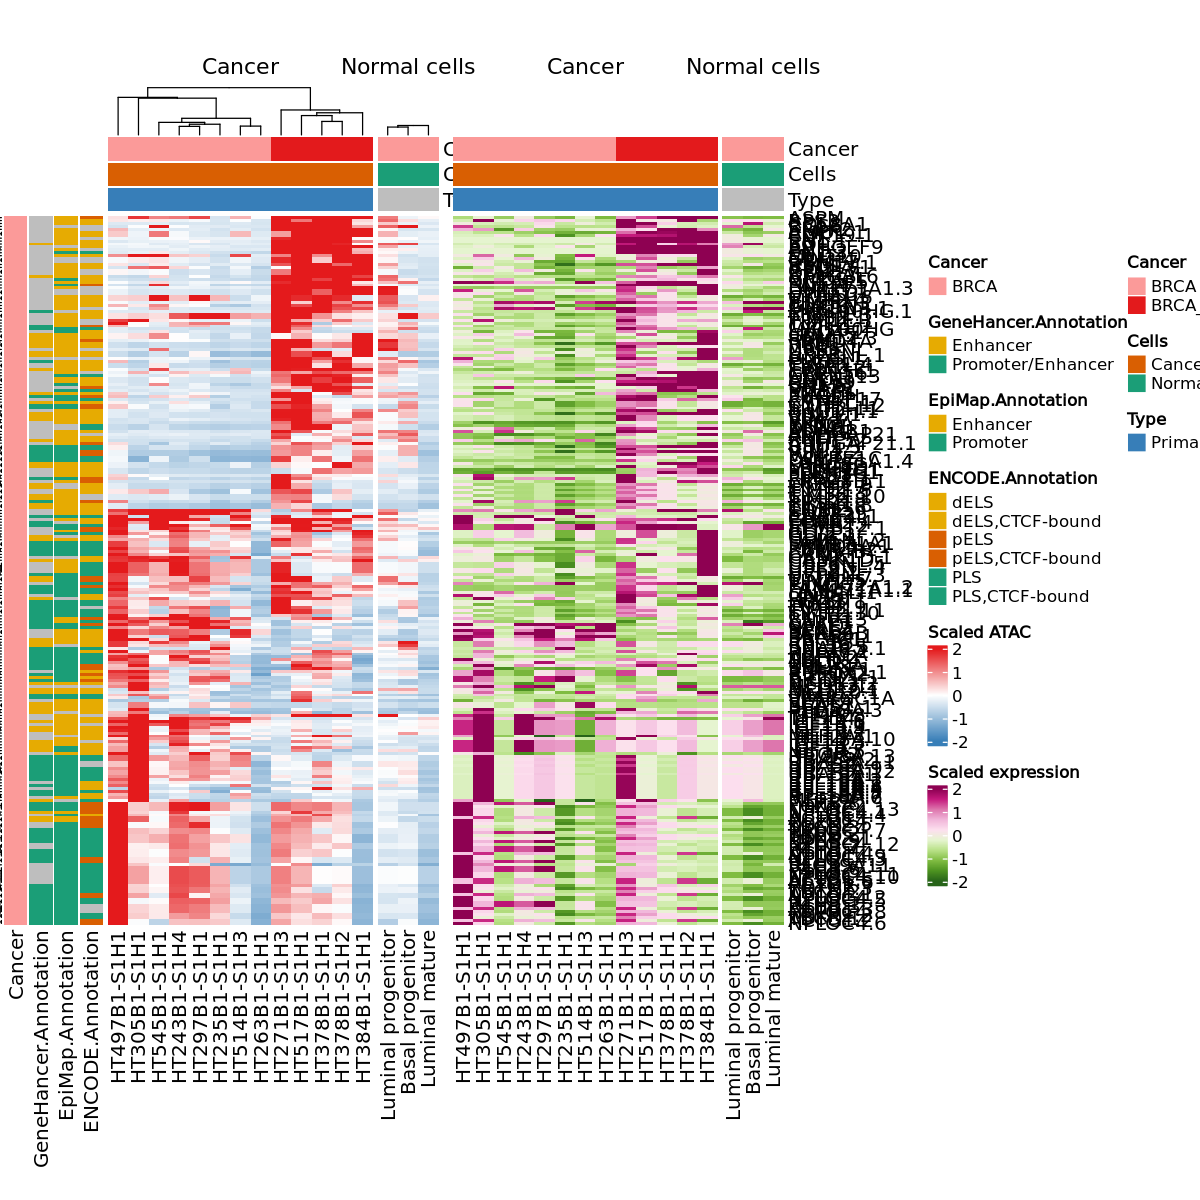

In [23]:
#Panel S6e
p + p2

# Make coverage plots

In [25]:
#some functions
get.plotting.region <- function(tb, gene.l, padding=0) {
    tb <- tb %>% filter(gene==gene.l)
    con.starts <- tb %>% pull(start) %>% as.numeric()
    con.ends <- tb %>% pull(end) %>% as.numeric()
    chrom <- tb$seqnames[1]
    
    region <- paste(chrom, 
                    min(c(con.starts, con.ends))-padding,
                    max(c(con.starts, con.ends))+padding,
            sep = '-')
    
    return (region %>% StringToGRanges())
} 

get.enhancer.location <- function(interesting.enhancers, gene.l) {
    #print(interesting.enhancers %>% filter(gene==gene))
    enh.tb <- interesting.enhancers %>% filter(gene==gene.l & EpiMap.Annotation!="")
    #print(dim(enh.tb))
    enh.tb.enhancer <- enh.tb %>% filter(EpiMap.Annotation=='Enhancer')
    enh.tb.promoter <- enh.tb %>% filter(EpiMap.Annotation!='Enhancer')

    if(nrow(enh.tb.enhancer)>0) {
        enh <- enh.tb.enhancer$EpiMap.Location %>% unique() %>% StringToGRanges()
        enh$color <- '#FFDE17'
        
    } else {
        print('no EpiMap enhancers')
        enh <- NULL
    }
    
    if (nrow(enh.tb.promoter)>0) {
        prom <- enh.tb.promoter$EpiMap.Location %>% unique() %>% StringToGRanges()
        prom$color <- '#1b9e77'
    } else {
        print('no EpiMap promoters')
        prom <- NULL
    }
    if (!is.null(enh) & !is.null(prom)) {
    final.ranges <- c(enh, prom)
    } else if(!is.null(enh)) { 
        final.ranges <- enh
    } else if(!is.null(prom)) { 
        final.ranges <- prom
    } else {
        final.ranges <- NULL
    }
        
    return(final.ranges)
}



linkPlot_from_df <- function(link.df, plot.region, cutoff=0, padding=0) {
    chromosome <- link.df$seqnames[1]
    link.df$group <- seq_len(length.out = nrow(x = link.df))
      link.df <- link.df %>% filter(score>=cutoff)
    df <- data.frame(
      x = c(link.df$start,
            (link.df$start + link.df$end) / 2,
            link.df$end),
      y = c(rep(x = 0, nrow(x = link.df)),
            rep(x = -1, nrow(x = link.df)),
            rep(x = 0, nrow(x = link.df))),
      group = rep(x = link.df$group, 3),
      score = rep(link.df$score, 3),
        Cancer = rep(x = link.df$Cancer, 3))
    
    df <- df %>% mutate(y = case_when(y==-1 ~ -score, TRUE ~ 0))
    lev <- df %>% filter(y<0) %>% arrange(desc(y)) %>% pull(group)
     df$group <- factor(df$group, levels = lev) 
    
    
    p <- ggplot() +
      ggforce::geom_bezier(data = df,
        mapping = aes_string(x = "x", y = "y", group = "group", color = "Cancer")) +
      geom_hline(yintercept = 0, color = 'grey') +
      scale_color_manual(values = colors)
    
    p <- p +
    theme_classic() +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) +
    
    ylab("Links") +
    xlab(label = paste0(chromosome, " position (bp)")) +
    xlim(c(GenomicRanges::start(x = plot.region)-padding, GenomicRanges::end(x = plot.region))+padding)
  return(p)

}




In [24]:
#open object
combo.pancan <- readRDS('/diskmnt/Projects/snATAC_primary/PanCan_ATAC_data_freeze/v7.0/Multiome/Merged_objects_PanCan_peaks/Pancan_level/out/Pancan_all_cells_multiome_obj.20230306.rds')
basal.piece.id <- c("HT268B1-Th1H3", "HT029B1-S1PC", "HT035B1-S1PA",
                 "HT1408-06","HT141B1-S1H1", "HT206B1-S1H4", "HT271B1-S1H3",
                "HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1")
non.squamous.cesc <- c('CE507-C1A2', 'CE354E1-S1', 'CE357E1-S1', 'CE336E1-S1', 'CE332E1-N1')
pdac.basal <- c('HT242P1-S1H1','HT264P1-S1H2', 'HT306P1-S1H1', 'HT390P1-S1H1', 'HT181P1-T1A3', 'HT090P1-T2A3', 
                'HT447P1-Th1K1A3', 'HT452P1-Th1K1', 'PM565P1-T1N1', 'PM1380P1-T1Y2')



normal.meta.pdac <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Normal_cell_typing_detailed/v7.0/PDAC/ATAC/cell_typing/PDAC_ATAC_normal_cell_type_combo_regular.tsv', header = T) %>%
    data.frame(row.names = 1)

normal.meta.crc <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Normal_cell_typing_detailed/v7.0/CRC/ATAC/cell_typing/CRC_ATAC_normal_cell_type_combo_regular.tsv', header = T) %>%
    data.frame(row.names = 1)


combo.pancan <- AddMetaData(combo.pancan, rbind(normal.meta.pdac, normal.meta.crc))
combo.pancan$cell_type.normal <- case_when(is.na(combo.pancan$cell_type.normal) ~ combo.pancan$cell_type.harmonized.cancer.atac,
                                 TRUE ~ combo.pancan$cell_type.normal)


combo.pancan@meta.data <- combo.pancan@meta.data %>% 
    mutate(Cancer.new = case_when((Piece_ID %in% basal.piece.id) & !is.na(Sample_type) ~ 'BRCA_Basal', 
                                  (Piece_ID %in% non.squamous.cesc) & !is.na(Sample_type) ~ 'CESC_Non-squamous',
                                  #(Piece_ID %in% pdac.basal) & !is.na(Sample_type) ~ 'PDAC_Basal',
                                  TRUE ~ Cancer)) %>%
    mutate(Cancer.common = case_when(Cancer.new %in% c('UCEC', 'OV') ~ 'UCEC&OV',
                                  Cancer.new %in% c('CESC', 'HNSCC') ~ 'HNSCC&CESC',
                                  TRUE ~ Cancer)) %>%
    mutate(Sample_type2 = case_when(Sample_type=='Tumor' ~ 'Primary',
                                   TRUE ~ Sample_type)) %>%
    mutate(Cancer_stage_cell_type.normal = case_when(cell_type.normal == 'Tumor' ~ paste(Cancer.new,Sample_type2, 'Cancer', cell_type.normal, sep='__' ),
               TRUE ~ paste(Cancer, 'Normal',cell_type.normal, sep='__')))  %>%
    mutate(Cancer_Piece_cell_type.normal = case_when(cell_type.normal == 'Tumor' ~ paste(Cancer,Sample_type2, Piece_ID, 'Cancer', cell_type.normal, sep='__' ),
               TRUE ~ paste(Cancer, 'Normal',cell_type.normal, sep='__')))  %>%
    mutate(Cancer_cell_type.normal = case_when(cell_type.normal == 'Tumor' ~ paste(Cancer.new, 'Cancer cells', sep='__' ),
           TRUE ~ paste(Cancer, 'Normal',cell_type.normal, sep='__')))




[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames          ranges strand
         <Rle>       <IRanges>  <Rle>
  [1]     chr2 9066222-9292801      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "PDAC__Primary__Cancer__Tumor" "PDAC__Normal__Ductal-like2"

Warning message:
“Removed 62 rows containing missing values (`geom_segment()`).”


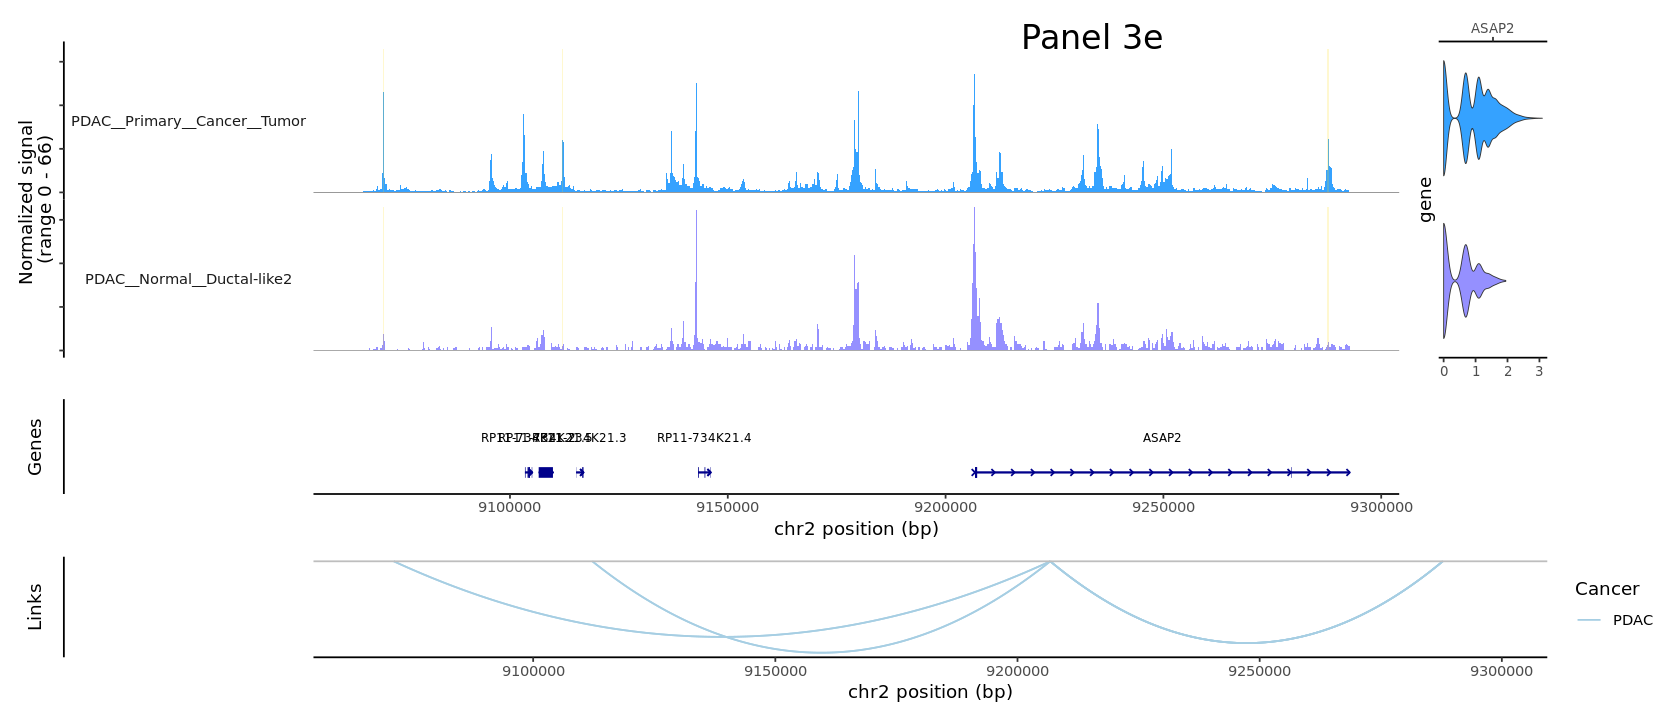

In [27]:
normal.cells <- list('CRC' = 'Stem|stem',
                    HNSCC = 'Normal squa', CESC = 'Normal squa',
                    BRCA = 'mature|Luminal pro', PDAC='like2', 
                    UCEC = 'Secretory', OV = 'Secretory', SKCM='Melano')


DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'PDAC'
gene.oi = 'ASAP2'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel 3e", x = 0.65, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]     chr3 12225034-12450263      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "PDAC__Primary__Cancer__Tumor" "PDAC__Normal__Ductal-like2"

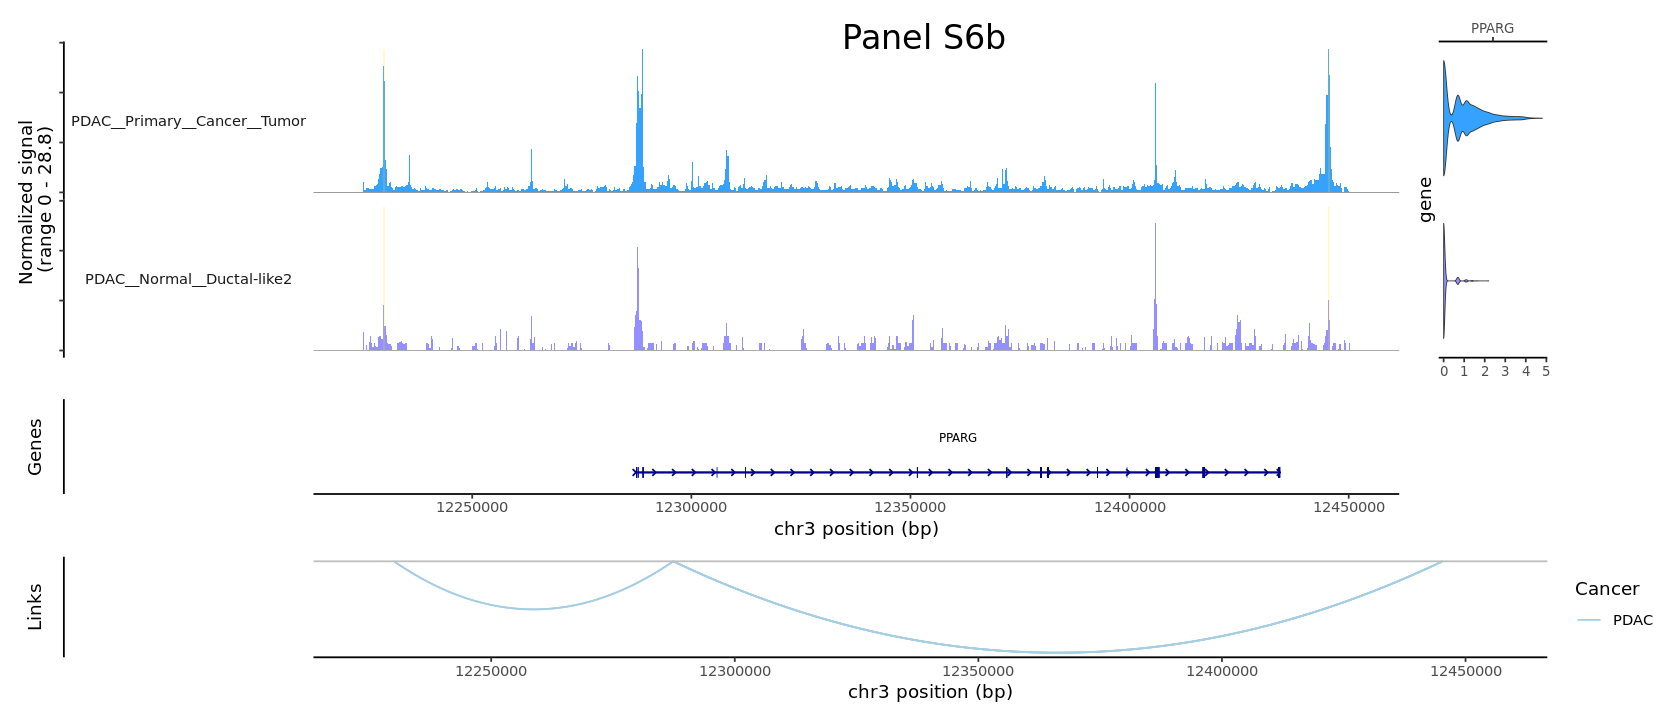

In [28]:
DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'PDAC'
gene.oi = 'PPARG'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel S6b", x = 0.55, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]     chr3 57954092-58013400      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "PDAC__Primary__Cancer__Tumor" "PDAC__Normal__Ductal-like2"

Warning message:
“Removed 267 rows containing missing values (`geom_segment()`).”


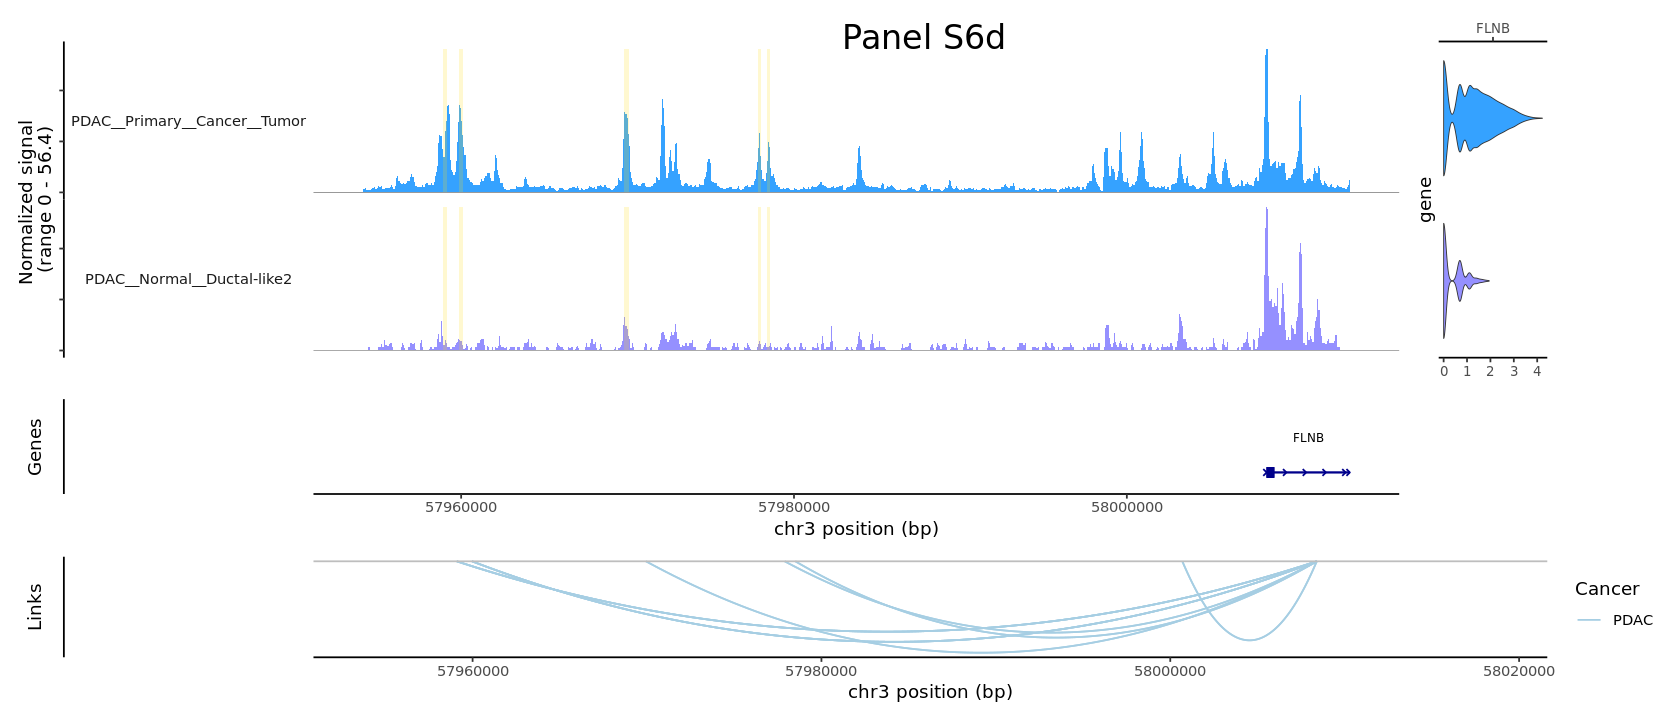

In [29]:
DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'PDAC'
gene.oi = 'FLNB'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel S6d", x = 0.55, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

[1] "no EpiMap promoters"


GRanges object with 1 range and 0 metadata columns:
      seqnames            ranges strand
         <Rle>         <IRanges>  <Rle>
  [1]     chr6 43690849-43884194      *
  -------
  seqinfo: 1 sequence from an unspecified genome; no seqlengths

[1] "BRCA__Normal__Luminal mature"       "BRCA__Normal__Luminal progenitor"  
[3] "BRCA_Basal__Primary__Cancer__Tumor"

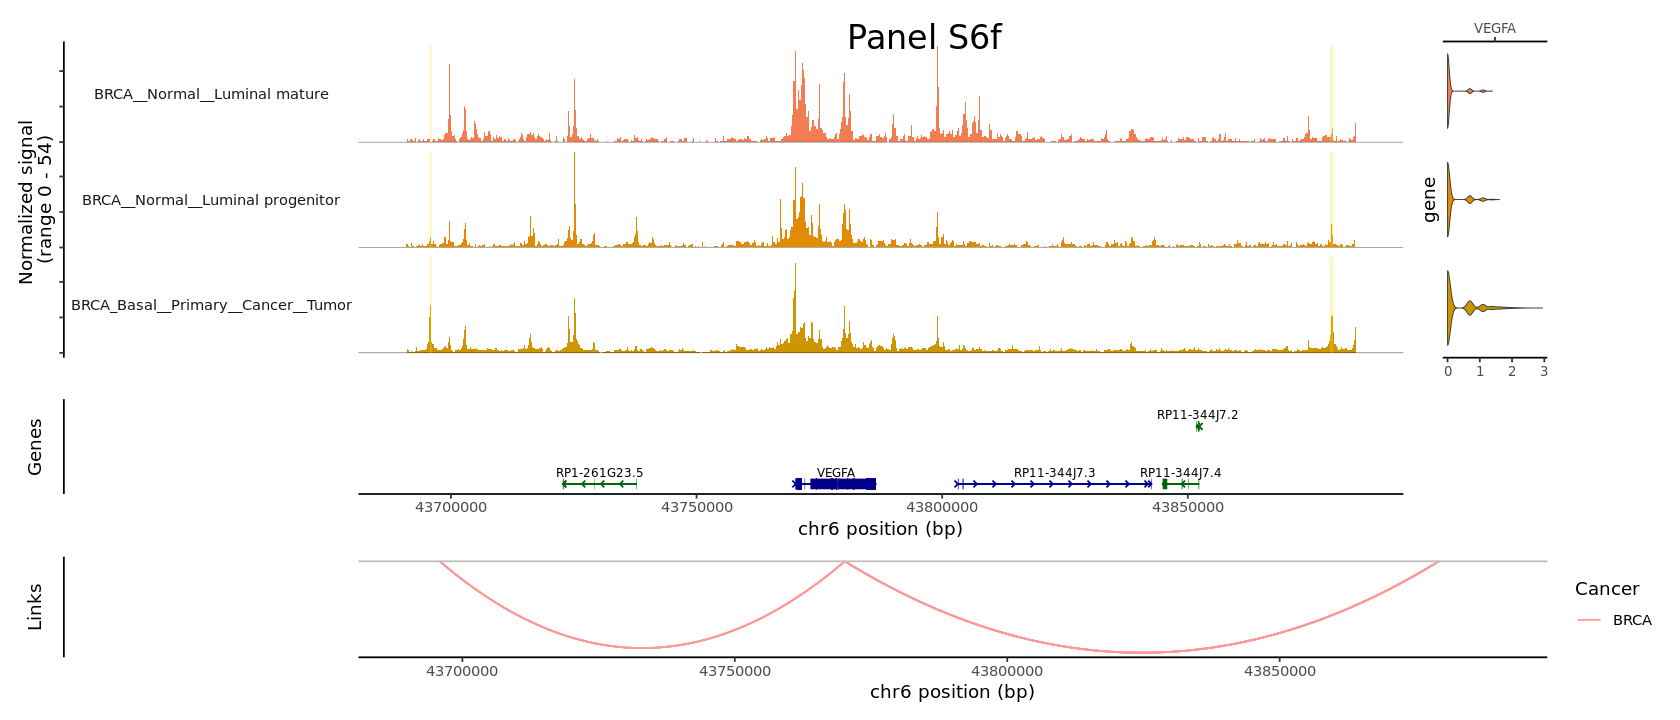

In [30]:
DefaultAssay(combo.pancan) <- 'pancan'

cancer.type = 'BRCA'
gene.oi = 'VEGFA'
interesting.connections <- all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(Cancer==cancer.type) 

region <- get.plotting.region(tb = interesting.connections, gene.l = gene.oi, padding = 5000)

ranges.enhancer <- get.enhancer.location((interesting.connections), gene.oi)

if(!is.null(ranges.enhancer)) {
        region <- GenomicRanges::reduce(c(region, ranges.enhancer))
}
region
Idents(combo.pancan) <- 'Cancer_stage_cell_type.normal'
toshow <- combo.pancan$Cancer_stage_cell_type.normal %>% unique
toshow <- toshow[(grepl(cancer.type, toshow) & grepl('Primary',toshow) & grepl('_Basal',toshow)) | grepl(normal.cells[[cancer.type]],toshow)]
toshow

coverage <- CoveragePlot(combo.pancan, region = region, idents = toshow,
                         #group.by = 'cell_type.piece', 
                         region.highlight = ranges.enhancer, 
                         expression.assay = 'SCT',features = gene.oi,
                        #max.downsample = 0.9,
                         peaks = FALSE,
                         ymax = 'q60', 
                         #ranges = ranges.motifs,
                         
                        links = FALSE)

new.links <- linkPlot_from_df((interesting.connections %>% filter(gene==gene.oi)), 
                              plot.region = region, cutoff = 0, padding = 5000)

p <- CombineTracks(plotlist = list(coverage, new.links), heights = c(9,2))

options(repr.plot.width=14, repr.plot.height=6)
p
grid.text("Panel S6f", x = 0.55, y = 0.95,
              gp = gpar(fontsize = 20))

#link panel has to be sized in adobe illustrator to match the scale on genes panel above it

In [310]:
all.links.filtered %>% filter(gene == 'FLNB' & Cancer == 'PDAC')

Cancer,gene,peak,seqnames,start,end,width,strand,score,zscore,⋯,ENCODE.Location,ENCODE.Accession,ENCODE.Annotation,ENCODE.Annotation_explained,Enhancer_gene_pair,Enhancer_gene_pair.in.genehancerInter,Peak.to.gene,cnv,N.cells.with.cnv,cnv.pct
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<chr>,<chr>,<int>,<dbl>
PDAC,FLNB,chr3-57597261-57597761,chr3,57597511,58008400,410890,*,0.08397006,4.312133,⋯,chr3-57597385-57597734,EH38E3517212,"PLS,CTCF-bound","Promoter-like cCRE, CTCF-bound",GH03J057594:FLNB,FALSE,chr3-57597261-57597761:FLNB,Gain,5390,0.1085162
PDAC,FLNB,chr3-57597261-57597761,chr3,57597511,58008400,410890,*,0.08397006,4.312133,⋯,chr3-57597385-57597734,EH38E3517212,"PLS,CTCF-bound","Promoter-like cCRE, CTCF-bound",GH03J057594:FLNB,FALSE,chr3-57597261-57597761:FLNB,Loss,7217,0.1452990
PDAC,FLNB,chr3-57692505-57693005,chr3,57692755,58008400,315646,*,0.07560084,3.278158,⋯,chr3-57692592-57692857,EH38E2205634,"pELS,CTCF-bound","Proximal enhancer-like cCRE, CTCF-bound",GH03J057690:FLNB,FALSE,chr3-57692505-57693005:FLNB,Gain,5390,0.1085162
PDAC,FLNB,chr3-57692505-57693005,chr3,57692755,58008400,315646,*,0.07560084,3.278158,⋯,chr3-57692592-57692857,EH38E2205634,"pELS,CTCF-bound","Proximal enhancer-like cCRE, CTCF-bound",GH03J057690:FLNB,FALSE,chr3-57692505-57693005:FLNB,Loss,7217,0.1452990
PDAC,FLNB,chr3-57692505-57693005,chr3,57692755,58008400,315646,*,0.07560084,3.278158,⋯,chr3-57692592-57692857,EH38E2205634,"pELS,CTCF-bound","Proximal enhancer-like cCRE, CTCF-bound",GH03J057690:FLNB,FALSE,chr3-57692505-57693005:FLNB,Gain,5390,0.1085162
PDAC,FLNB,chr3-57692505-57693005,chr3,57692755,58008400,315646,*,0.07560084,3.278158,⋯,chr3-57692592-57692857,EH38E2205634,"pELS,CTCF-bound","Proximal enhancer-like cCRE, CTCF-bound",GH03J057690:FLNB,FALSE,chr3-57692505-57693005:FLNB,Loss,7217,0.1452990
PDAC,FLNB,chr3-57693671-57694171,chr3,57693921,58008400,314480,*,0.07283316,7.359884,⋯,chr3-57693778-57694096,EH38E3517245,pELS,Proximal enhancer-like cCRE,GH03J057690:FLNB,FALSE,chr3-57693671-57694171:FLNB,Gain,5390,0.1085162
PDAC,FLNB,chr3-57693671-57694171,chr3,57693921,58008400,314480,*,0.07283316,7.359884,⋯,chr3-57693778-57694096,EH38E3517245,pELS,Proximal enhancer-like cCRE,GH03J057690:FLNB,FALSE,chr3-57693671-57694171:FLNB,Loss,7217,0.1452990
PDAC,FLNB,chr3-57693671-57694171,chr3,57693921,58008400,314480,*,0.07283316,7.359884,⋯,chr3-57693778-57694096,EH38E3517245,pELS,Proximal enhancer-like cCRE,GH03J057690:FLNB,FALSE,chr3-57693671-57694171:FLNB,Gain,5390,0.1085162


In [251]:
all.links.tumor.normal %>% filter(gene=='ASAP2') %>% filter(Cancer=='OV')

Cancer,gene,peak,seqnames,start,end,width,strand,score,zscore,⋯,Enhancer_gene_pair,Enhancer_gene_pair.in.genehancerInter,Peak.to.gene,cnv,N.cells.with.cnv,cnv.pct,DAP.tumor,DEG.tumor,DAP.met,DEG.met
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,⋯,<chr>,<lgl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
OV,ASAP2,chr2-9003502-9004002,chr2,9003752,9206765,203014,*,0.08562766,2.798641,⋯,NA:ASAP2,FALSE,chr2-9003502-9004002:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9003502-9004002,chr2,9003752,9206765,203014,*,0.08562766,2.798641,⋯,NA:ASAP2,FALSE,chr2-9003502-9004002:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9142626-9143126,chr2,9142876,9206765,63890,*,0.08026452,4.746239,⋯,GH02J009142:ASAP2,TRUE,chr2-9142626-9143126:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9178285-9178785,chr2,9178535,9206765,28231,*,0.09616458,7.666661,⋯,GH02J009177:ASAP2,TRUE,chr2-9178285-9178785:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9178901-9179401,chr2,9179151,9206765,27615,*,0.09779323,7.630830,⋯,GH02J009177:ASAP2,TRUE,chr2-9178901-9179401:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9178901-9179401,chr2,9179151,9206765,27615,*,0.09779323,7.630830,⋯,GH02J009177:ASAP2,TRUE,chr2-9178901-9179401:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9179765-9180265,chr2,9180015,9206765,26751,*,0.08026354,5.445544,⋯,GH02J009177:ASAP2,TRUE,chr2-9179765-9180265:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9234759-9235259,chr2,9206765,9235009,28245,*,0.10548718,7.731939,⋯,GH02J009233:ASAP2,TRUE,chr2-9234759-9235259:ASAP2,Gain,3317,0.1473502,Down in tumor,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9423295-9423795,chr2,9206765,9423545,216781,*,0.09238599,3.096813,⋯,GH02J009421:ASAP2,FALSE,chr2-9423295-9423795:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested


In [255]:
all.links.tumor.normal %>% 
    filter(!(paste(gene, Cancer, sep ='_') %in% genes.gained)) %>% 
    #filter((grepl('Up', DEG.tumor) & grepl('Up', DAP.tumor)) ) %>%
    filter(grepl('Up', DEG.tumor) ) %>%  filter(gene=='ASAP2')  %>%
    filter(Cancer=='OV') 

Cancer,gene,peak,seqnames,start,end,width,strand,score,zscore,⋯,Enhancer_gene_pair,Enhancer_gene_pair.in.genehancerInter,Peak.to.gene,cnv,N.cells.with.cnv,cnv.pct,DAP.tumor,DEG.tumor,DAP.met,DEG.met
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>,<dbl>,⋯,<chr>,<lgl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>
OV,ASAP2,chr2-9003502-9004002,chr2,9003752,9206765,203014,*,0.08562766,2.798641,⋯,NA:ASAP2,FALSE,chr2-9003502-9004002:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9003502-9004002,chr2,9003752,9206765,203014,*,0.08562766,2.798641,⋯,NA:ASAP2,FALSE,chr2-9003502-9004002:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9142626-9143126,chr2,9142876,9206765,63890,*,0.08026452,4.746239,⋯,GH02J009142:ASAP2,TRUE,chr2-9142626-9143126:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9178285-9178785,chr2,9178535,9206765,28231,*,0.09616458,7.666661,⋯,GH02J009177:ASAP2,TRUE,chr2-9178285-9178785:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9178901-9179401,chr2,9179151,9206765,27615,*,0.09779323,7.630830,⋯,GH02J009177:ASAP2,TRUE,chr2-9178901-9179401:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9178901-9179401,chr2,9179151,9206765,27615,*,0.09779323,7.630830,⋯,GH02J009177:ASAP2,TRUE,chr2-9178901-9179401:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9179765-9180265,chr2,9180015,9206765,26751,*,0.08026354,5.445544,⋯,GH02J009177:ASAP2,TRUE,chr2-9179765-9180265:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9234759-9235259,chr2,9206765,9235009,28245,*,0.10548718,7.731939,⋯,GH02J009233:ASAP2,TRUE,chr2-9234759-9235259:ASAP2,Gain,3317,0.1473502,Down in tumor,Up in tumor,Not tested,Not tested
OV,ASAP2,chr2-9423295-9423795,chr2,9206765,9423545,216781,*,0.09238599,3.096813,⋯,GH02J009421:ASAP2,FALSE,chr2-9423295-9423795:ASAP2,Gain,3317,0.1473502,Not tested,Up in tumor,Not tested,Not tested


In [145]:
atac.pancan.aver.Piece.normal <- readRDS('/diskmnt/Projects/snATAC_primary/PanCan_ATAC_data_freeze/v7.0/snATAC/Merged_objects_PanCan_peaks/Averaged.objects/Averaged_Cancer_normal_Pancan_225Samples_1000cellsPerCluster_TumorNormal.200PCs.chromVar.20230118.rds')

In [149]:
atac.pancan.aver.Piece.normal@meta.data

,orig.ident,nCount_pancan,nFeature_pancan,Cancer
,<fct>,<dbl>,<int>,<chr>
BRCA__Cancer__Tumor,BRCA,9466.043,1235710,BRCA
BRCA__Normal__Basal progenitor,BRCA,4755.299,853028,BRCA
BRCA__Normal__Luminal mature,BRCA,4014.132,756392,BRCA
BRCA__Normal__Luminal progenitor,BRCA,6698.560,924734,BRCA
BRCA_Basal__Normal__Basal progenitor,BRCA,8541.918,346431,BRCA_Basal
BRCA_Basal__Normal__Luminal mature,BRCA,8195.827,593997,BRCA_Basal
BRCA_Basal__Normal__Luminal progenitor,BRCA,9120.549,571233,BRCA_Basal
ccRCC__Cancer__Tumor,ccRCC,8629.343,1235702,ccRCC
ccRCC__Normal__Collecting Duct Intercalated Cells A,ccRCC,11719.604,738271,ccRCC


In [146]:
epimap <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Annotate.peaks/v7.0/Peaks_overlapping_with_EpiMap_promoters_enhancers.txt')
enhancer.peaks <- epimap %>% filter(EpiMap.Annotation=='Enhancer') %>% pull(Peak) %>% unique
promoter.peaks <- epimap %>% filter(EpiMap.Annotation=='Promoter') %>% pull(Peak) %>% unique




In [147]:
genehancer <- fread('/diskmnt/Projects/snATAC_analysis/tumor_Alla/Annotate.peaks/v7.0/Peaks_overlapping_with_GeneHancer_enhancers_and_promoter_enhancers.txt')
enhancer.peaks <- genehancer %>% filter(GeneHancer.Annotation=='Enhancer') %>% pull(Peak) %>% unique
promoter.peaks <- genehancer %>% filter(GeneHancer.Annotation=='Promoter/Enhancer') %>% pull(Peak) %>% unique



In [142]:
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'pancan'
toplot <- FetchData(combo.pancan.aver.Piece.normal, vars = enhancer.peaks, slot='scale.data')
head(toplot)


,chr1-100347032-100347532,chr1-100360073-100360573,chr1-100360692-100361192,chr1-100361643-100362143,chr1-100362765-100363265,chr1-100387107-100387607,chr1-100387898-100388398,chr1-100394069-100394569,chr1-100395911-100396411,chr1-100396575-100397075,⋯,chrX-9865963-9866463,chrX-9866571-9867071,chrX-9867168-9867668,chrX-9905240-9905740,chrX-9906916-9907416,chrX-9907700-9908200,chrX-9909184-9909684,chrX-9980348-9980848,chrX-9980908-9981408,chrX-9981452-9981952
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRCA__HT235B1-S1H1__Tumor,0.14740799,0.22980819,-0.1473191,-0.1391326,-0.22152177,-0.2701018,-0.2071741,-0.489688402,-0.7792830,-0.6382955,⋯,-0.5974840,-0.51120437,-0.26936698,-0.3355192,-0.64831211,-0.5116843,-0.21080594,-0.3434676,-0.78318139,-0.4216167
BRCA__HT243B1-S1H4__Tumor,-0.51725389,0.22980819,-0.3142476,-0.3869803,-0.24814545,-0.4459863,-0.2071741,0.006568691,-0.4725379,-0.3418987,⋯,-0.4718070,-0.36869601,0.04922928,-0.2233875,-0.09178518,-0.3225525,0.59619987,-0.1467887,-0.05124718,-0.3328739
BRCA__HT263B1-S1H1__Tumor,-0.51725389,-0.04709836,-0.6486044,-0.3869803,-0.27479575,-0.4459863,-0.5341961,-0.241312222,-0.4725379,-0.6382955,⋯,-0.5974840,-0.65399746,-0.26936698,-0.2233875,-0.58923706,-0.5590853,-0.75015325,-0.2450791,-0.53895963,-0.5993680
BRCA__HT268B1-Th1H3__Tumor,5.17806304,4.07780216,4.4603944,3.7931723,0.01690267,0.2564993,0.6075336,0.253956308,2.5781670,1.4302872,⋯,0.2744585,0.05713197,3.82368808,-0.3355192,-0.61875991,-0.2282684,-0.48034489,0.5385091,3.81579857,5.1702420
BRCA__HT271B1-S1H3__Tumor,-0.07392482,-0.60174065,0.3524707,-0.1391326,-0.22152177,-0.4459863,-0.3706034,-0.241312222,0.4458619,1.1356574,⋯,-0.4299981,-0.51120437,-0.10998952,-0.3355192,-0.44206123,-0.3697649,0.05846415,-0.2450791,0.92126695,0.1977335
BRCA__HT297B1-S1H1__Tumor,-0.29547864,-0.87947750,-0.4813426,-0.8834187,-0.22152177,-0.4459863,-0.2071741,0.377465743,0.1400339,-0.3418987,⋯,-0.4299981,-0.29754825,-0.26936698,0.4470640,0.13945910,-0.3225525,-0.21080594,0.2453940,-0.29498172,-0.2442195


In [ ]:
toplot.cor <- cor(t(toplot))
head(toplot.cor)

In [ ]:
breaks = seq(-0.5 ,0.5, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(c( '#377eb8','white','#e41a1c'))(length(breaks)))

meta <- combo.pancan.aver.Piece.normal@meta.data
basal.piece.id <- c("HT268B1-Th1H3", "HT029B1-S1PC", "HT035B1-S1PA",
 "HT1408-06","HT141B1-S1H1", "HT206B1-S1H4", "HT271B1-S1H3",
"HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1")
non.squamous.cesc <- c('CE507-C1A2', 'CE354E1-S1', 'CE357E1-S1', 'CE336E1-S1', 'CE332E1-N1')
pdac.basal <- c('HT242P1-S1H1','HT264P1-S1H2', 'HT306P1-S1H1', 'HT390P1-S1H1', 'HT181P1-T1A3', 'HT090P1-T2A3', 
                'HT447P1-Th1K1A3', 'HT452P1-Th1K1', 'PM565P1-T1N1', 'PM1380P1-T1Y2')

meta$Cancer.new <- case_when(meta$Cancer == 'BRCA' & !is.na(meta$Sample_type) & meta$Piece_ID %in% basal.piece.id ~ 'BRCA_Basal',
                             meta$Cancer == 'CESC' & !is.na(meta$Sample_type) & meta$Piece_ID %in% non.squamous.cesc ~ 'CESC_Non-squamous',
                            meta$Cancer == 'PDAC' & !is.na(meta$Sample_type) & meta$Piece_ID %in% pdac.basal ~ 'PDAC_Basal',
                            TRUE ~ meta$Cancer)

column_ha = HeatmapAnnotation(Cancer = meta$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.cor)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                              Type = meta$Sample_type,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Tumor' = '#377eb8', 'Met' = '#e41a1c'))
)

options(repr.plot.width=10, repr.plot.height=10)

p <- Heatmap(toplot.cor, name = "Pearson's r", cluster_column_slices = F,
             col = color.palette, cluster_rows = T, show_row_names = F,
             show_column_names = F, 
             top_annotation = column_ha,
             #left_annotation = row_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
            #column_split = col.split, 
             width = unit(15, "cm"), height = unit(15, "cm"))

p

pdf('Cor_heatmap_geneHancer_enhancer.averaged.ward.D2.pdf', width = 15, height= 15)
p
dev.off()

In [122]:
hclust(method = 'h')

ERROR: Error in hclust(method = "h"): invalid clustering method h


In [129]:
VariableFeatures(combo.pancan)

[1] "ANKRD30A"      "CPB1"          "GP2"           "GRID2"        
   [5] "MIR4300HG"     "XACT"          "SFTPB"         "PTPRQ"        
   [9] "AL583785.1"    "ERBB4"         "CSMD1"         "SCGB2A2"      
  [13] "KCNC2"         "LRP1B"         "SLC4A4"        "CNTN5"        
  [17] "SYT1"          "DCT"           "PNLIPRP1"      "PNLIP"        
  [21] "LINC02306"     "IGKC"          "LINC02582"     "LHFPL3-AS1"   
  [25] "CUZD1"         "PCDH11X"       "FN1"           "AP001977.1"   
  [29] "TPH1"          "AL357507.1"    "RBPJL"         "SMYD3"        
  [33] "TRPM1"         "CELA3A"        "TRPS1"         "KRT6A"        
  [37] "IGHGP"         "CPA1"          "LSAMP"         "ESR1"         
  [41] "AC004704.1"    "ROBO2"         "SGCG"          "NLGN1"        
  [45] "REG1A"         "TRPM3"         "CLCA1"         "SLC26A3"      
  [49] "AC112770.1"    "CFTR"          "GRIA2"         "SNTG1"        
  [53] "SERPINE1"      "MUC19"         "SPON1"         "CELA3B"       
  [57] "LINC01320"     "MUC2"          "CPA2"          "NXPH1"        
  [61] "SGCD"          "LINC02109"     "IGLC2"         "TYR"          
  [65] "KRT13"         "PRSS1"         "LINC01924"     "AC024230.1"   
  [69] "MIR217HG"      "CDH6"          "LINC01206"     "FAM155A"      
  [73] "AC012078.2"    "CTNNA2"        "AL159156.1"    "MYBPC1"       
  [77] "ANXA1"         "MT-CO2"        "GLRA3"         "RELN"         
  [81] "SFTPC"         "CEL"           "IGHG1"         "BRINP3"       
  [85] "NRG3"          "MGP"           "NRG1"          "MT-CO3"       
  [89] "PGC"           "ABCB1"         "SGCZ"          "TMPRSS11B"    
  [93] "OCA2"          "PTPRT"         "KCNJ3"         "IGHG3"        
  [97] "ADARB2"        "AC010624.5"    "IL24"          "IGHA1"        
 [101] "HEPHL1"        "SLC14A2"       "PKHD1L1"       "KRT6C"        
 [105] "RHEX"          "IGHG4"         "AKAP6"         "MTRNR2L12"    
 [109] "KCNIP4"        "LRRTM4"        "GREM2"         "BICC1"        
 [113] "CYP4Z1"        "AC011246.1"    "LINC00621"     "TYRP1"        
 [117] "MT-CO1"        "APOE"          "NPAS3"         "AFF3"         
 [121] "AL079338.1"    "MT-ATP6"       "KHDRBS2"       "PI15"         
 [125] "OLFM4"         "GRM8"          "ANKRD30B"      "NOX1"         
 [129] "GRIA1"         "NTM"           "LINC02476"     "DLGAP1"       
 [133] "SLC26A7"       "HS3ST2"        "AC111198.1"    "ZNF804B"      
 [137] "MUC5B"         "CRP"           "SMOC2"         "COL11A1"      
 [141] "LINC02511"     "NPSR1"         "IGLC1"         "NELL1"        
 [145] "COL1A2"        "PMEL"          "SELE"          "TNC"          
 [149] "NRXN1"         "NOL4"          "LUZP2"         "SLC26A4"      
 [153] "FCGBP"         "AC005909.2"    "TGM3"          "RALYL"        
 [157] "SPRR3"         "PDE4D"         "MUC6"          "KRT14"        
 [161] "SLCO1B7"       "FER1L6"        "NRXN3"         "LINC02548"    
 [165] "UBE2D2"        "LINC00342"     "AC120193.1"    "DCD"          
 [169] "AMY2A"         "CTRB1"         "IGLC3"         "MT2A"         
 [173] "AC073114.1"    "REG4"          "AGBL1"         "MIR205HG"     
 [177] "ABCB5"         "RIMS2"         "LINC01208"     "TFF2"         
 [181] "PKHD1"         "XKR4"          "ZNF385B"       "HS6ST3"       
 [185] "FBXL7"         "DNAH9"         "DIO2"          "COL25A1"      
 [189] "ADAMTSL1"      "HS3ST4"        "CALB1"         "TEX41"        
 [193] "MRPS30-DT"     "GPC5"          "LAMC2"         "AC004949.1"   
 [197] "AC025839.1"    "GALNTL6"       "NDRG1"         "PIK3C2G"      
 [201] "LINC02141"     "CLCA4"         "MALRD1"        "EPHA7"        
 [205] "SYNPO2"        "COL1A1"        "LINC01811"     "INS"          
 [209] "SERPINB2"      "CDH19"         "ABCC11"        "AC012494.1"   
 [213] "COL3A1"        "CACNA2D3"      "DACH1"         "HMCN1"        
 [217] "MAGI2"         "KCND2"         "PRSS2"         "CFAP299"      
 [221] "DMBT1"         "CHODL"         "AC093001.1"    "NKD1"         
 [225] "ACSM3"         "AC1

In [134]:
DefaultAssay(combo.pancan.aver.Piece.normal) <- 'SCT'
toplot <- FetchData(combo.pancan.aver.Piece.normal, vars = rownames(combo.pancan), slot='scale.data')
head(toplot)
toplot.cor <- cor(t(toplot))
head(toplot.cor)

,MIR1302-2HG,OR4F5,AL627309.1,AL627309.2,AL627309.5,AL627309.4,AP006222.2,AL732372.1,AC114498.1,AL669831.2,⋯,AL592183.1,AC240274.1,AC213203.1,AC004556.3,AC233755.1,AC136612.1,AC136616.1,AC023491.2,AC007325.4,AC007325.2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BRCA__HT235B1-S1H1__Tumor,-0.2374575,-0.1679195,-0.76119138,-0.2319066,-0.84214864,-0.4885959,0.0628515,-0.1407111,-0.4014293,2.2024668,⋯,-0.2872360,-0.8230795,-0.178996,0.06012198,-0.1830914,-0.1330088,1.1765420,-0.2888363,0.42857402,-0.54735486
BRCA__HT243B1-S1H4__Tumor,-0.2374575,-0.1679195,0.61337705,-0.2319066,0.20430415,0.2497075,-0.4004547,-0.1407111,-0.4014293,-0.5752987,⋯,0.7601398,-0.7977538,-0.178996,0.23281266,-0.1830914,-0.1330088,-0.2877589,-0.2888363,0.55918102,-0.45591704
BRCA__HT263B1-S1H1__Tumor,-0.2374575,-0.1679195,2.30152012,-0.2319066,0.01652063,-0.4885959,0.5256951,-0.1407111,-0.4014293,0.1201830,⋯,0.9329118,1.2679417,-0.178996,-0.28577650,-0.1830914,-0.1330088,-0.2877589,-0.2888363,-0.09515292,-0.45591704
BRCA__HT268B1-Th1H3__Tumor,-0.2374575,-0.1679195,0.01468101,-0.2319066,-0.36232174,-0.4885959,-0.4004547,-0.1407111,2.2269769,-0.5752987,⋯,-0.6784154,0.4133849,-0.178996,-0.11274096,-0.1830914,-0.1330088,-0.2877589,-0.2888363,0.03597417,0.45346953
BRCA__HT271B1-S1H3__Tumor,-0.2374575,-0.1679195,-0.93455371,-0.2319066,-1.03607377,-0.4885959,-0.4004547,-0.1407111,-0.4014293,-0.5752987,⋯,-0.4181759,-0.5458699,-0.178996,-0.11274096,-0.1830914,-0.1330088,-0.2877589,-0.2888363,1.08031781,0.09079894
BRCA__HT297B1-S1H1__Tumor,-0.2374575,-0.1679195,-0.76119138,-0.2319066,-0.74561681,-0.4885959,1.4499982,-0.1407111,-0.4014293,-0.5752987,⋯,-0.6624746,-0.8484303,-0.178996,-0.45898500,-0.1830914,-0.1330088,-0.2877589,-0.2888363,2.11644627,2.77641848


,BRCA__HT235B1-S1H1__Tumor,BRCA__HT243B1-S1H4__Tumor,BRCA__HT263B1-S1H1__Tumor,BRCA__HT268B1-Th1H3__Tumor,BRCA__HT271B1-S1H3__Tumor,BRCA__HT297B1-S1H1__Tumor,BRCA__HT305B1-S1H1__Tumor,BRCA__HT378B1-S1H1__Tumor,BRCA__HT378B1-S1H2__Tumor,BRCA__HT384B1-S1H1__Tumor,⋯,SKCM__ML1984M1-Ty1__Tumor,SKCM__ML225M1-Ty1__Tumor,SKCM__ML499M1-S1__Tumor,SKCM__Normal__Keratinocytes,SKCM__Normal__Melanocytes,UCEC__CPT1541DU-T1__Tumor,UCEC__CPT2373DU-S1__Tumor,UCEC__CPT704DU-S1__Tumor,UCEC__Normal__Ciliated Endometrial epithelial cells,UCEC__Normal__Secretory Endometrial epithelial cells
BRCA__HT235B1-S1H1__Tumor,1.00000000,0.21580470,0.25690843,0.02064194,0.05738666,0.25723141,0.11136202,-0.032246820,-0.012547040,-0.047899567,⋯,-0.050556408,0.016629868,-0.002823218,0.033237777,0.026410865,0.02137882,0.03151632,-0.038695954,0.062095104,0.048709137
BRCA__HT243B1-S1H4__Tumor,0.21580470,1.00000000,0.40660639,0.05171160,0.05475373,0.35703278,0.24666877,-0.008580475,0.049894018,0.001880605,⋯,-0.063116034,-0.001858041,-0.009111979,0.031467101,-0.006818616,0.07691783,0.02111927,-0.009227279,0.054023701,0.030431045
BRCA__HT263B1-S1H1__Tumor,0.25690843,0.40660639,1.00000000,0.02151845,0.05066880,0.38327381,0.14519697,-0.008512966,-0.030904965,0.028215264,⋯,-0.074182574,0.025994398,-0.059756014,0.064152359,0.001692941,0.07449161,0.02755203,-0.009518789,0.084045228,0.089040024
BRCA__HT268B1-Th1H3__Tumor,0.02064194,0.05171160,0.02151845,1.00000000,0.17260288,0.05447431,0.07365907,0.044605583,0.159361994,0.250794694,⋯,0.007907399,0.051835962,0.116520623,-0.033900396,-0.015557531,0.07975289,0.01301900,-0.031069651,-0.003017328,-0.004175120
BRCA__HT271B1-S1H3__Tumor,0.05738666,0.05475373,0.05066880,0.17260288,1.00000000,0.06463530,0.10198022,0.042423813,0.166950587,0.156662902,⋯,-0.007143843,0.090680886,0.055860184,0.020517467,0.038082216,0.06305840,0.06067240,0.014504358,0.013190688,0.010643033
BRCA__HT297B1-S1H1__Tumor,0.25723141,0.35703278,0.38327381,0.05447431,0.06463530,1.00000000,0.25371306,-0.036916893,0.006202427,-0.008736705,⋯,-0.056223180,-0.003139676,0.015826500,-0.001201871,-0.023284926,0.14181940,0.02454751,-0.023842009,0.038244842,0.001690834


png 
  2

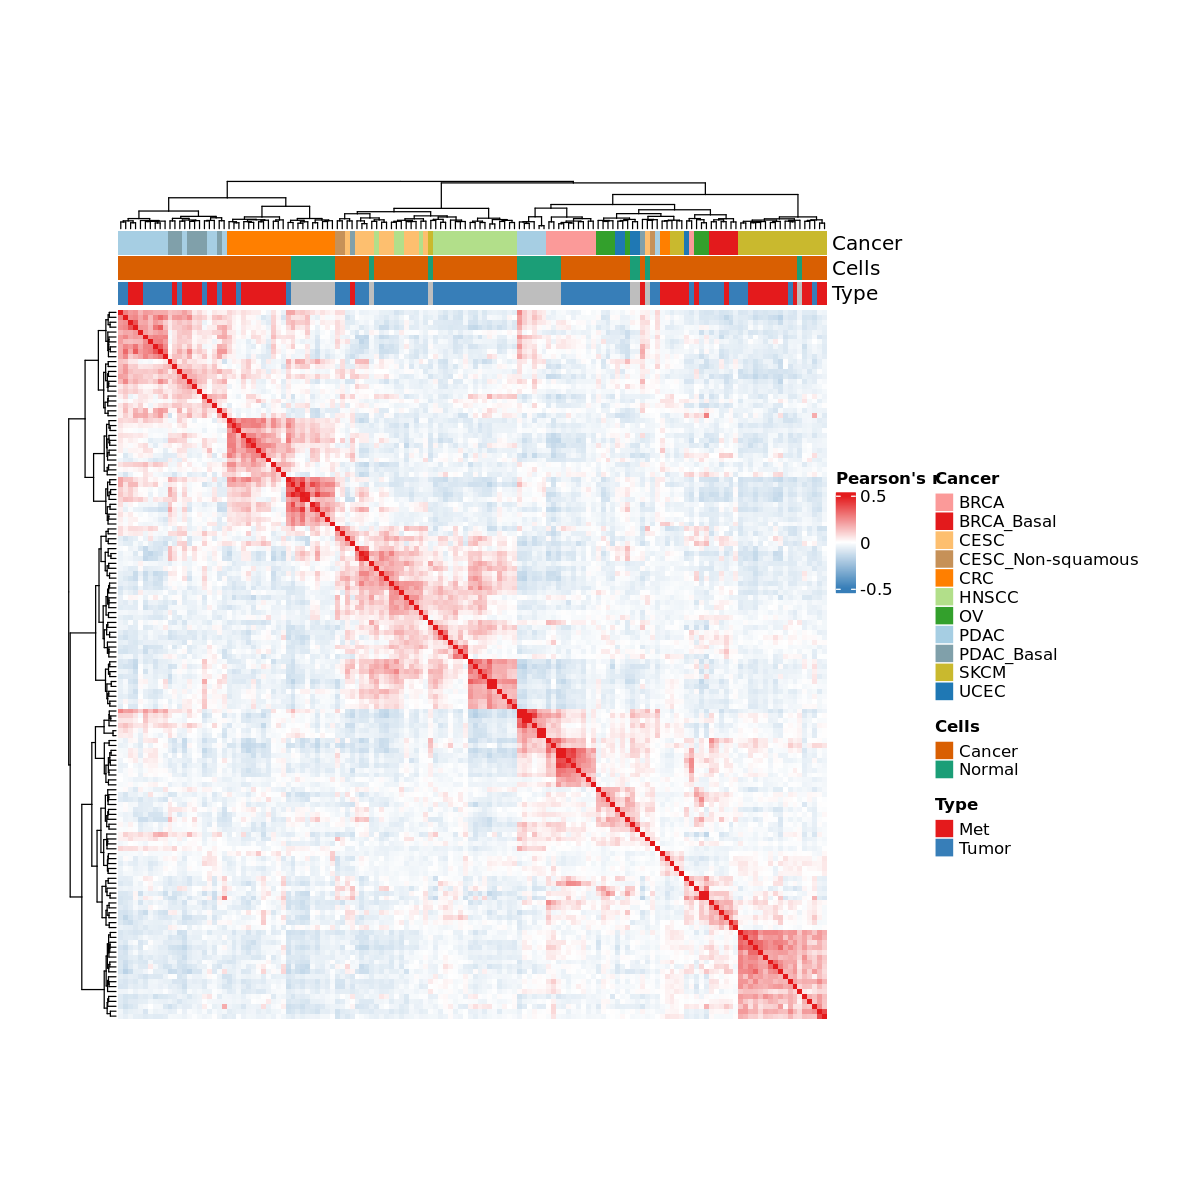

In [135]:
breaks = seq(-0.5 ,0.5, by=0.001)
color.palette <- circlize::colorRamp2(breaks = breaks, 
                                      colors = colorRampPalette(c( '#377eb8','white','#e41a1c'))(length(breaks)))

meta <- combo.pancan.aver.Piece.normal@meta.data
basal.piece.id <- c("HT268B1-Th1H3", "HT029B1-S1PC", "HT035B1-S1PA",
 "HT1408-06","HT141B1-S1H1", "HT206B1-S1H4", "HT271B1-S1H3",
"HT378B1-S1H1", "HT378B1-S1H2", "HT384B1-S1H1", "HT517B1-S1H1")
non.squamous.cesc <- c('CE507-C1A2', 'CE354E1-S1', 'CE357E1-S1', 'CE336E1-S1', 'CE332E1-N1')
pdac.basal <- c('HT242P1-S1H1','HT264P1-S1H2', 'HT306P1-S1H1', 'HT390P1-S1H1', 'HT181P1-T1A3', 'HT090P1-T2A3', 
                'HT447P1-Th1K1A3', 'HT452P1-Th1K1', 'PM565P1-T1N1', 'PM1380P1-T1Y2')

meta$Cancer.new <- case_when(meta$Cancer == 'BRCA' & !is.na(meta$Sample_type) & meta$Piece_ID %in% basal.piece.id ~ 'BRCA_Basal',
                             meta$Cancer == 'CESC' & !is.na(meta$Sample_type) & meta$Piece_ID %in% non.squamous.cesc ~ 'CESC_Non-squamous',
                            meta$Cancer == 'PDAC' & !is.na(meta$Sample_type) & meta$Piece_ID %in% pdac.basal ~ 'PDAC_Basal',
                            TRUE ~ meta$Cancer)

column_ha = HeatmapAnnotation(Cancer = meta$Cancer.new,
                              Cells = case_when(grepl('Tumor', colnames(toplot.cor)) ~ 'Cancer',
                                                TRUE ~ 'Normal'),
                              Type = meta$Sample_type,
                              col = list(Cancer = colors,
                                        Cells = c('Cancer' = '#d95f02', 'Normal' = '#1b9e77'),
                                        Type = c('Tumor' = '#377eb8', 'Met' = '#e41a1c'))
)

options(repr.plot.width=10, repr.plot.height=10)

p <- Heatmap(toplot.cor, name = "Pearson's r", cluster_column_slices = F,
             col = color.palette, cluster_rows = T, show_row_names = F,
             show_column_names = F, 
             top_annotation = column_ha,
             #left_annotation = row_ha,
             clustering_method_columns = 'ward.D2',clustering_method_rows = 'ward.D2',
           #bottom_annotation = ha,  #cluster_rows = row_dend,
            #column_split = col.split, 
             width = unit(15, "cm"), height = unit(15, "cm"))

p

pdf('Cor_heatmap_all.genes.averaged.ward.D2.pdf', width = 15, height= 15)
p
dev.off()

In [132]:
rownames(combo.pancan)

[1] "MIR1302-2HG"       "OR4F5"             "AL627309.1"       
    [4] "AL627309.2"        "AL627309.5"        "AL627309.4"       
    [7] "AP006222.2"        "AL732372.1"        "AC114498.1"       
   [10] "AL669831.2"        "LINC01409"         "FAM87B"           
   [13] "LINC01128"         "LINC00115"         "FAM41C"           
   [16] "AL645608.6"        "AL645608.2"        "AL645608.4"       
   [19] "LINC02593"         "SAMD11"            "NOC2L"            
   [22] "KLHL17"            "PLEKHN1"           "PERM1"            
   [25] "AL645608.7"        "HES4"              "ISG15"            
   [28] "AL645608.1"        "AGRN"              "AL645608.5"       
   [31] "AL645608.8"        "RNF223"            "C1orf159"         
   [34] "AL390719.3"        "LINC01342"         "AL390719.2"       
   [37] "TTLL10-AS1"        "TTLL10"            "TNFRSF18"         
   [40] "TNFRSF4"           "SDF4"              "B3GALT6"          
   [43] "C1QTNF12"          "AL162741.1"        "UBE2J2"           
   [46] "LINC01786"         "SCNN1D"            "ACAP3"            
   [49] "PUSL1"             "INTS11"            "AL139287.1"       
   [52] "CPTP"              "TAS1R3"            "DVL1"             
   [55] "MXRA8"             "AURKAIP1"          "CCNL2"            
   [58] "MRPL20-AS1"        "MRPL20"            "AL391244.2"       
   [61] "ANKRD65"           "AL391244.1"        "TMEM88B"          
   [64] "LINC01770"         "VWA1"              "ATAD3C"           
   [67] "ATAD3B"            "ATAD3A"            "TMEM240"          
   [70] "SSU72"             "AL645728.1"        "FNDC10"           
   [73] "AL691432.4"        "AL691432.2"        "MIB2"             
   [76] "MMP23B"            "CDK11B"            "FO704657.1"       
   [79] "SLC35E2B"          "CDK11A"            "SLC35E2A"         
   [82] "NADK"              "GNB1"              "AL109917.1"       
   [85] "CALML6"            "TMEM52"            "CFAP74"           
   [88] "AL391845.2"        "GABRD"             "AL391845.1"       
   [91] "PRKCZ"             "AL590822.2"        "PRKCZ-AS1"        
   [94] "FAAP20"            "AL590822.1"        "SKI"              
   [97] "AL590822.3"        "MORN1"             "AL589739.1"       
  [100] "AL513477.2"        "RER1"              "PEX10"            
  [103] "PLCH2"             "AL139246.1"        "AL139246.4"       
  [106] "PANK4"             "HES5"              "AL139246.5"       
  [109] "TNFRSF14-AS1"      "TNFRSF14"          "AL139246.3"       
  [112] "PRXL2B"            "MMEL1"             "TTC34"            
  [115] "AC242022.2"        "AC242022.1"        "AL589702.1"       
  [118] "PRDM16-DT"         "PRDM16"            "AL008733.1"       
  [121] "AL590438.1"        "AL354743.2"        "AL354743.1"       
  [124] "ARHGEF16"          "AL512413.1"        "MEGF6"            
  [127] "AL513320.1"        "TPRG1L"            "WRAP73"           
  [130] "TP73"              "AL136528.1"        "AL136528.2"       
  [133] "CCDC27"            "SMIM1"             "LRRC47"           
  [136] "AL365330.1"        "CEP104"            "DFFB"             
  [139] "C1orf174"          "LINC01134"         "LINC01346"        
  [142] "LINC01345"         "LINC02780"         "AL805961.1"       
  [145] "LINC01777"         "LINC01646"         "AJAP1"            
  [148] "Z98886.1"          "LINC02781"         "Z98259.3"         
  [151] "AL365255.1"        "NPHP4"             "KCNAB2"           
  [154] "CHD5"              "RPL22"             "AL031847.1"       
  [157] "RNF207"            "ICMT"              "LINC00337"        
  [160] "GPR153"            "ACOT7"             "AL031848.2"       
  [163] "HES2"              "ESPN"              "AL031848.1"       
  [166] "TNFRSF25"          "PLEKHG5"           "NOL9"             
  [169] "TAS1R1"            "ZBTB48"            "KLHL21"           
  [172] "PHF13"             "THAP3"             "DNAJC11"          
  [175] "LINC01672"         "AL591163.1"        "CAMTA1-DT" 